In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import pandas as pd
import seaborn as sns
# sns.set_style('whitegrid')

import covid19

## data

In [3]:
data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
# data_italy_path = covid19.data.download('andamento-nazionale')

In [4]:
data_italy = pd.read_csv(data_italy_path, parse_dates=['data'], index_col=['data'])
data_italy.index = data_italy.index.normalize()

for column in ['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']:
    data_italy['variazione_' + column] = data_italy[column].diff(1)

data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,variazione_ricoverati_con_sintomi,variazione_terapia_intensiva,variazione_deceduti
data,,,,,,,,,,,,,,
2020-03-18,ITA,14363,2257,16620,12090,28710,2648,4025,2978,35713,165541,1469.0,197.0,475.0
2020-03-19,ITA,15757,2498,18255,14935,33190,4480,4440,3405,41035,182777,1394.0,241.0,427.0
2020-03-20,ITA,16020,2655,18675,19185,37860,4670,5129,4032,47021,206886,263.0,157.0,627.0
2020-03-21,ITA,17708,2857,20565,22116,42681,4821,6072,4825,53578,233222,1688.0,202.0,793.0
2020-03-22,ITA,19846,3009,22855,23783,46638,3957,7024,5476,59138,258402,2138.0,152.0,651.0


## situation report

In [5]:
START_FIT = '2020-02-23'
STOP_FIT = '2020-03-22'
EXTRAPOLTATE = ('2020-02-26', '2020-03-24')

In [6]:
fits = {}
fits['dimessi_guariti'] = covid19.fit.ExponentialFit.from_frame('dimessi_guariti', data_italy, start='2020-03-08', stop=STOP_FIT)
fits['totale_casi_1'] = covid19.fit.ExponentialFit.from_frame('totale_casi', data_italy, start=START_FIT, stop='2020-02-29')
fits['totale_casi'] = covid19.fit.ExponentialFit.from_frame('totale_casi', data_italy, start='2020-03-01', stop='2020-03-09')

fits['ricoverati_con_sintomi_1'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start=START_FIT, stop='2020-03-06')
fits['ricoverati_con_sintomi_2'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-09', stop='2020-03-18')
fits['terapia_intensiva_1'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start=START_FIT, stop='2020-03-06')
fits['terapia_intensiva_2'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-07', stop='2020-03-13')
fits['terapia_intensiva_3'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-14', stop='2020-03-18')
fits['deceduti_1'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start=START_FIT, stop='2020-03-11')

fits['ricoverati_con_sintomi'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-20', stop=STOP_FIT)
fits['terapia_intensiva'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-19', stop=STOP_FIT)
fits['deceduti'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start='2020-03-12', stop=STOP_FIT)


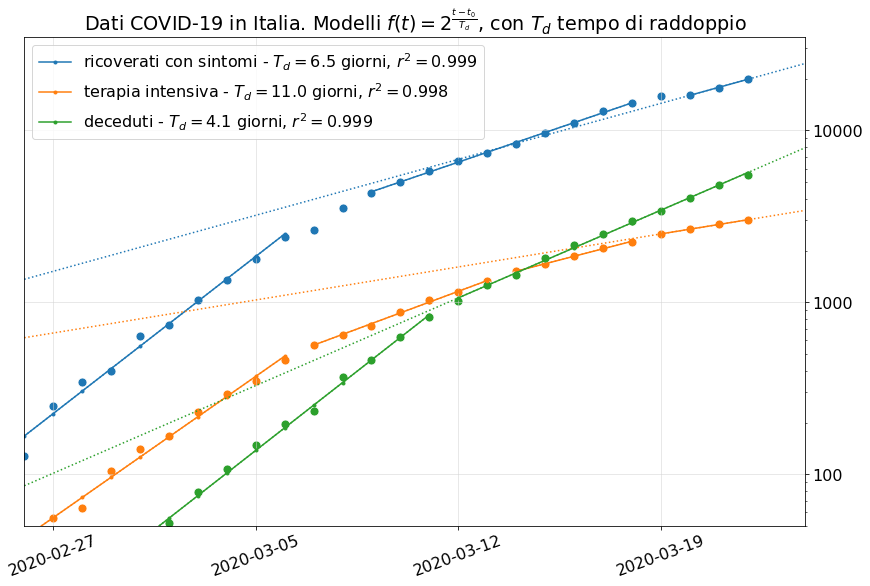

In [7]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (50, 35000)})
# _ = covid19.plot.add_events(ax, linestyle=':', offset=11, color='grey')

covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_1'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_2'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_1'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_2'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_3'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_1'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=color, date_interval=7)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio')
_ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.xaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.yaxis.tick_right()
_ = ax.legend(loc='upper left')


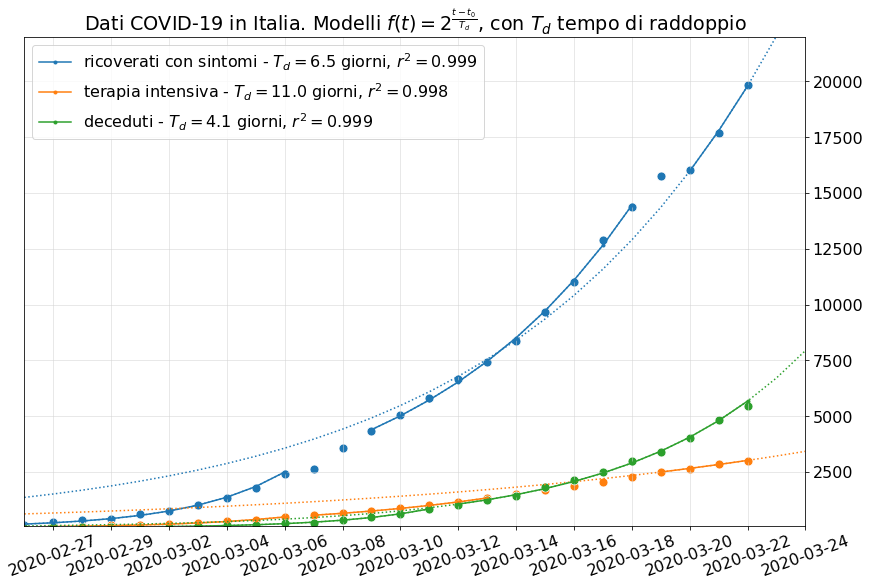

In [13]:
_, ax = plt.subplots(subplot_kw={'yscale': 'linear', 'ylim': (80, 22000)})
# _ = covid19.plot.add_events(ax, linestyle=':', offset=17, color='grey')

covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_1'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_2'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_1'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_2'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_1'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=color, date_interval=2)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio')
_ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.xaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.yaxis.tick_right()


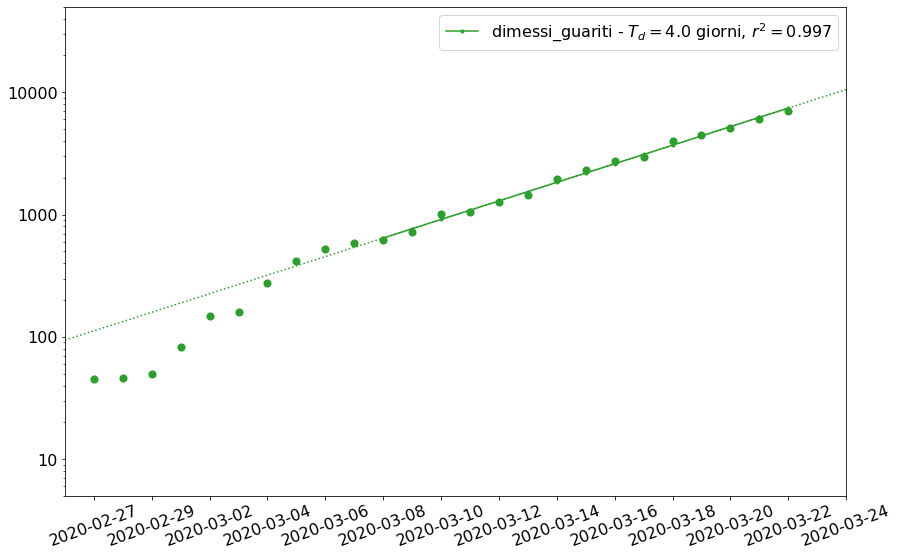

In [9]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 50000)})
kind = 'dimessi_guariti'
covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind, extrapolate=EXTRAPOLTATE, color=color)


## estimates

In [10]:
kinds = ['deceduti', 'terapia_intensiva', 'ricoverati_con_sintomi', 'dimessi_guariti']
datetime_expected = '2020-03-23'
expected_values = []
for kind in kinds:
    expected_values.append(int(round(fits[kind].predict(datetime_expected))))
print(', '.join(f'{k}: {v}' for v, k in zip(expected_values, kinds)))

deceduti: 6717, terapia_intensiva: 3218, ricoverati_con_sintomi: 22038, dimessi_guariti: 8844


In [11]:
for key, value in list(fits.items()):
    print(f'{key} {" " * (26 - len(key))}{str(value)}')

dimessi_guariti            T_d=3.97, t_0='2020-01-30', r^2=0.997 start='2020-03-08', stop='2020-03-22'
totale_casi_1              T_d=2.11, t_0='2020-02-07', r^2=0.995 start='2020-02-24', stop='2020-02-29'
totale_casi                T_d=3.27, t_0='2020-01-26', r^2=1.000 start='2020-03-01', stop='2020-03-09'
ricoverati_con_sintomi_1   T_d=2.31, t_0='2020-02-08', r^2=0.995 start='2020-02-24', stop='2020-03-06'
ricoverati_con_sintomi_2   T_d=5.24, t_0='2020-01-05', r^2=0.999 start='2020-03-09', stop='2020-03-18'
terapia_intensiva_1        T_d=2.56, t_0='2020-02-12', r^2=0.996 start='2020-02-24', stop='2020-03-06'
terapia_intensiva_2        T_d=4.81, t_0='2020-01-23', r^2=0.999 start='2020-03-07', stop='2020-03-13'
terapia_intensiva_3        T_d=6.92, t_0='2019-12-31', r^2=1.000 start='2020-03-14', stop='2020-03-18'
deceduti_1                 T_d=2.29, t_0='2020-02-17', r^2=0.999 start='2020-02-24', stop='2020-03-11'
ricoverati_con_sintomi     T_d=6.47, t_0='2019-12-20', r^2=0.999 start='2